## **공통 라이브러리 및 드라이브 연동**




In [2]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt 
import math
import cv2
impath = '/content/drive/My Drive/Colab Notebooks/Image_processing/image/lena.bmp'
savepath = '/content/drive/My Drive/Colab Notebooks/Image_processing/image/lena_video.avi'

Mounted at /content/drive


## **1번 Convert RGB color image to gray**

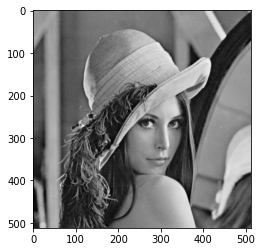

In [ ]:
def rgb_to_gray(image):
    R = image_color[:,:,0]*0.3 # R채널에 0.3의 가중치를 곱함
    G = image_color[:,:,1]*0.5 # G 채널에 0.5의 가중치를 곱함
    B = image_color[:,:,2]*0.2 # B 채널에 0.2의 가중치를 곱함
    image_out = R + G + B #각 가중치를 곱한 채널의 픽셀값을 더함
    return image_out

image_color = cv2.imread(impath, cv2.IMREAD_COLOR)
image_color = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB) #cv2.imread로 읽을경우 RGB순서가 다르기 때문에 순서를 바꿔줌

input = image_color
output = rgb_to_gray(input)
plt.imshow(output,cmap='gray') #gray scale로 출력


## **2번 Change the input image intensity**

In [ ]:
def linear_operation(image, offset):
  height_len, width_len, channel_len = image.shape # 각 행렬 길이 값 저장
  # 512*512*3 for문 반복
  for channel in range(channel_len):
    for width in range(width_len):
      for height in range(height_len):
          if offset > 0 : # offset > 0 인경우 상한 값 255
              image[height, width, channel] = min(image[height, width, channel] + offset, 255)
          else : # 나머지의 경우 하한 값 0
              image[height, width, channel] = max(image[height, width, channel] + offset, 0)
  return image

origin_image = cv2.imread(impath,cv2.IMREAD_COLOR)
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)

change_image = linear_operation(origin_image, 70) # 함수 적용

plt.imshow(change_image)

## **3번 Generate the video by cropping 128x128 block from 512x512 image using the following order**

In [ ]:
def spiral_scan(image):
  # Video Setup
  image_size = image.shape # (512, 512, 3)
  frame_size = (128, 128)
  fps = 120
  fourcc = cv2.VideoWriter_fourcc(*'DIVX')
  video = cv2.VideoWriter(savepath, fourcc, fps, frame_size)

  # [0,0] -> [384,0] 
  for i in range(image_size[1]-frame_size[1]+1): 
    frame = image[0:frame_size[0], i:frame_size[1]+i]
    video.write(frame)
  # [384,0] -> [384,384]
  for i in range(image_size[0]-frame_size[0]+1):
    frame = image[i:frame_size[0]+i, image_size[1]-frame_size[1]:image_size[1]]
    video.write(frame)
  # [384,384] -> [0,384] 
  for i in range(image_size[1]-frame_size[1]+1):
    frame = image[image_size[0]-frame_size[0]:image_size[0], image_size[1]-frame_size[1]-i:image_size[1]-i]
    video.write(frame)

  # [0,384] -> [0,128]
  for i in range(image_size[0]-frame_size[0]-frame_size[0]+1):
    frame = image[image_size[0]-frame_size[0]-i:image_size[0]-i, 0:frame_size[1]]
    video.write(frame)
  # [0,128] -> [256,128] 
  for i in range(image_size[1]-frame_size[1]-frame_size[1]+1):
    frame = image[frame_size[0]:frame_size[0]+frame_size[0], 0+i:frame_size[1]+i]
    video.write(frame)

  # [256,128] -> [256,256] 
  for i in range(image_size[0]-frame_size[0]-frame_size[0]-frame_size[0]+1):
    frame = image[frame_size[0]+i:frame_size[0]+frame_size[0]+i, image_size[1]-frame_size[1]-frame_size[1]:image_size[1]-frame_size[1]]
    video.write(frame)
  # [256,256] -> [128,256] 
  for i in range(image_size[1]-frame_size[1]-frame_size[1]-frame_size[1]+1):
    frame = image[image_size[0]-frame_size[0]-frame_size[0]:image_size[0]-frame_size[0], image_size[1]-frame_size[1]-frame_size[1]-i:image_size[1]-frame_size[1]-i]
    video.write(frame)
  print(frame[127][127][2])

  video.release()
  return video

image = cv2.imread(impath,cv2.IMREAD_COLOR)
output = spiral_scan(image)

171


## **4번 Find the histogram for given input gray image**

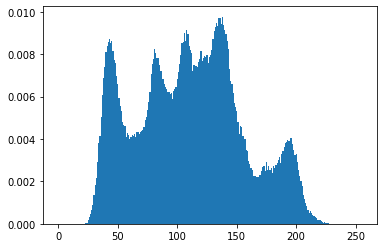

In [ ]:
def histogram(image,bins):

    h_hat = np.zeros((bins,1)) #정규화 될 히스토그램
    h = np.zeros((bins,1)) #정규화 하지 않은 히스토그램
    for x in range(512):
        for y in range(512):
            h[image[y,x]] = h[image[y,x]] + 1 #명암값에 해당하는 히스토그램 1증가

    for L in range(bins):        
        h_hat[L] = h[L]/(512*512) #정규화 하기 위해 M*N으로 나눔
            
    return h_hat

input = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) 
bins = 256
output = histogram(input,256) 
x = range(output.shape[0]) #히스토그램 x축 범위
plt.bar(x,output[:,0],width = 1.0) #정규화된 히스토그램 출력
plt.show()

## 먼저 각 픽셀마다 히스토그램의 x축에 대응하는 값이 있다면 수를 1 증가시키는 방법으로 N*1의 배열을 만든 후
## 픽셀의 총 개수 M*N으로 나누어 히스토그램을 정규화 하였다.


## **5번 Binarize the input image using Otsu method**

T =  110


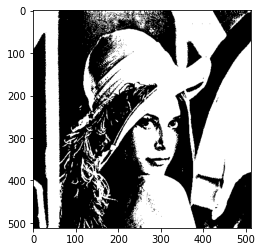

In [ ]:
def image_binarization(image):
    w0 = np.zeros((256,1)) #계산에 필요한 변수 선언
    u0 = np.zeros((256,1))
    u1 = np.zeros((256,1))
    v = np.zeros((256,1))
    h_hat = np.zeros((256,1))
    h_hat = histogram(image,256) #4번에서 사용한 히스토그램 함수 사용
    w0[0] = h_hat[0][0] # w0의 초깃값
    u0[0] = 0 # u0의 초깃값
    u = 0 

    for i in range(256):
        u = u + h_hat[i][0]*i # u 값 계산   u0[0] = 0 # u0의 초깃값

    for t in range(1,256): 
        w0[t] = w0[t-1] + h_hat[t]  
        u0[t] = (w0[t-1]*u0[t-1] + t*h_hat[t])/(w0[t]+0.00001) #0으로 나눠지만 안도록 0.00001을 더함
        u1[t] = (u-w0[t]*u0[t])/(1-w0[t]+0.00001) #0으로 나눠지만 안도록 0.00001을 더함
        v[t] = w0[t]*(1-w0[t])*pow((u0[t]-u1[t]),2) 
    T = np.argmax(v) #v(t)의 최댓값을 갖게 하는 T 값을 구함
    print('T = ',T)
    for x in range(512):
        for y in range(512): # 각 픽셀값이 
            if image[y,x] >= T: # threshold 값 이상이면
                image[y,x] = 1
            else:
                image[y,x] = 0
    return image

input = cv2.imread(impath, cv2.IMREAD_GRAYSCALE)
output = image_binarization(input)
plt.imshow(output, cmap='gray')
## 이진화를 하기위한 T(threshold) 값을 계산하기 위해 t에 따라 변하는 변수값을 선언해 주고 교과서 식(2.9)를
## 참고하여 t에 따른 V_beetween 값을 계산하도록 하였고, argmax 함수를 이용해 최댓값을 갖도록 하는 T값을
## 구하여 영상의 각픽셀값과 비교하여 이진화 하였다.
